In [1]:
from tensorflow.compat.v1 import ConfigProto, GPUOptions, InteractiveSession

if 'session' in globals():
    print('Session close and recreate')
    session.close()   

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import os

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import abc
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import random
import time
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D
import matplotlib.ticker as ticker
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
with open('data/train_data.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('data/test_data.pkl', 'rb') as f:
    submission_set = pickle.load(f)
with open('data/train_labels.pkl', 'rb') as f:
    Y_train = pickle.load(f)

In [6]:
CLASS_NAMES=["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42)

In [8]:
x_test_set=np.asarray(submission_set)/255.0

In [8]:
def make_file_structure(dirname):
    os.mkdir(os.getcwd()+'/'+dirname)
    os.mkdir(os.getcwd()+"/"+dirname+'/train')
    os.mkdir(os.getcwd()+"/"+dirname+'/test')
    for classname in CLASS_NAMES:
        os.mkdir(os.getcwd()+"/"+dirname+'/train/'+classname)
        os.mkdir(os.getcwd()+"/"+dirname+'/test/'+classname)

In [9]:
make_file_structure('ds4')

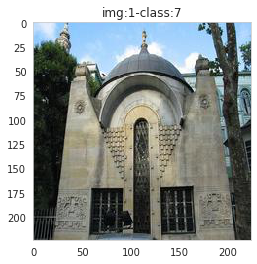

In [9]:
def plot_image(collection,number,labels=None,predicted=None):
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax=plt.imshow(collection[number])
    title='img:'+str(number)
    if labels is not None:
        title+='-class:'+CLASS_NAMES[labels[number]]
    if predicted is not None:
        title+='-pred:'+CLASS_NAMES[predicted[number]]
    plt.title(title)
    plt.show()

plot_image(x_train,1,labels=y_train)

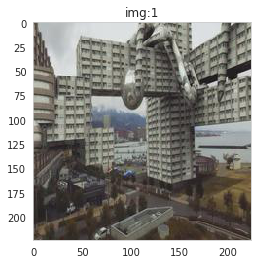

In [10]:
plot_image(x_test_set,1)

In [12]:
def save_train_val_datasets(dirname):
    for i in range(len(x_train)):
        cv2.imwrite(dirname+'/train/'+str(y_train[i])+'/'+str(i)+'.jpg', cv2.cvtColor(x_train[i], cv2.COLOR_RGB2BGR))
    for i in range(len(x_test)):
        cv2.imwrite(dirname+'/test/'+str(y_test[i])+'/'+str(i)+'.jpg', cv2.cvtColor(x_test[i], cv2.COLOR_RGB2BGR))

In [13]:
save_train_val_datasets('ds4')

In [11]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
TRAIN_PATH = 'ds4/train'
VALIDATION_PATH = 'ds4/test'

In [12]:
image_generator_sample = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen_sample = image_generator_sample.flow_from_directory(directory=TRAIN_PATH,
                                                     batch_size=32,
                                                     shuffle=True,
                                                     target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                     classes = list(CLASS_NAMES))
test_data_gen_sample = image_generator_sample.flow_from_directory(directory=VALIDATION_PATH,
                                                     batch_size=32,
                                                     shuffle=True,
                                                     target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                     classes = list(CLASS_NAMES))

Found 8262 images belonging to 14 classes.
Found 2066 images belonging to 14 classes.


In [13]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[np.argmax(label_batch[n],axis=-1)])
      plt.axis('off')

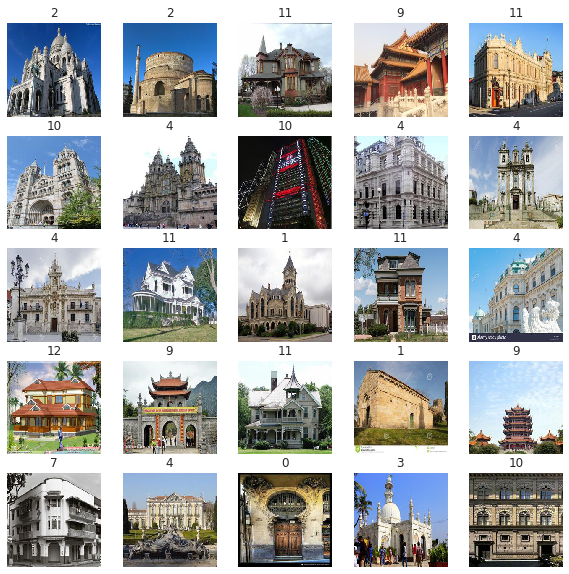

In [14]:
image_batch, label_batch = next(train_data_gen_sample)
show_batch(image_batch, label_batch)

In [15]:
class ConvolutionBlock(tf.keras.Model):
    def __init__(self, pooling_type,kernel_size,filters,batch_norm,residual):
        super(ConvolutionBlock, self).__init__()
        self.batch_norm=batch_norm
        self.residual=residual

        self.conv = Conv2D( kernel_size=kernel_size,strides=(1, 1),padding='same',filters=filters)
        self.batch_norm=BatchNormalization()
        self.activation=Activation('relu')
        self.pooling=self.createPoolingLayer(pooling_type)  
    
    def createPoolingLayer(self,pooling_type):
        if pooling_type == 'max':
            return MaxPooling2D(pool_size=(3,3),strides=(2, 2))  
        else:
            if pooling_type == 'average':
                return AveragePooling2D(pool_size=(3,3),strides=(2, 2)) 
            else:
                return None
    

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        if(self.batch_norm):
            x = self.batch_norm(x)
        
        if(self.residual):
            x = x + inputs
        x = self.activation(x)
        if(self.pooling != None):
            x = self.pooling(x)
        return x

In [18]:
class BlockCNNModel(tf.keras.Model):

    def __init__(self,pooling_type,kernel_size,first_dense_size,dropout,batch_norm,residual):
        super(BlockCNNModel, self).__init__()
        
        self.dropout=dropout
        
        self.conv_block1=ConvolutionBlock(pooling_type,kernel_size,64,batch_norm,residual=False) 
        self.conv_block2=ConvolutionBlock(pooling_type,kernel_size,64,batch_norm,residual=True) 
        self.conv_block3=ConvolutionBlock(pooling_type,kernel_size,64,batch_norm,residual=True)
        self.conv_block4=ConvolutionBlock(pooling_type,kernel_size,64,batch_norm,residual=True)
        self.conv_block5=ConvolutionBlock(pooling_type,kernel_size,64,batch_norm,residual=True)
        
        self.conv_list=[self.conv_block2,self.conv_block3,self.conv_block4]
        
        self.flatten = Flatten()
        
        self.d1 = Dense(first_dense_size, activation='relu')
        if(self.dropout!=None):
            self.dropout1=Dropout(dropout)
        self.d2 = Dense(256, activation='relu')
        if(self.dropout!=None):
            self.dropout2=Dropout(dropout)
        self.d3 = Dense(64, activation='relu')
        if(self.dropout!=None):
            self.dropout3=Dropout(dropout)
        self.d4 = Dense(14, activation='softmax')
         
        #STATISTICS
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]

        
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.conv_block1(inputs)
        for conv in self.conv_list:
            x=conv(x)
        print(x.shape)
        
        x = self.flatten(x)
        print(x.shape)
        x = self.d1(x)
        if(self.dropout!=None):
            x=self.dropout1(x)
        x = self.d2(x)
        if (self.dropout!=None):
            x=self.dropout2(x)
        x = self.d3(x)
        if (self.dropout!=None):
            x=self.dropout3(x)
        return self.d4(x)
    

    def predict(self, x):
        res=self.call(x)
        return np.argmax(res,axis=-1)
        
    
    @tf.function
    def train_step(self,images, labels,optimizer,loss_function, train_loss_metric,train_accuracy):
        print("trainstep")
        with tf.GradientTape() as tape:
            predictions = self(images)
            loss = loss_function(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        train_loss_metric(loss)
        train_accuracy(labels, predictions)
        
    @tf.function
    def test_step(self,images, labels,loss_function,test_loss_metric,test_accuracy):
        predictions = self(images)
        t_loss = loss_function(labels, predictions)
        test_loss_metric(t_loss)
        test_accuracy(labels, predictions)

    def fit(self,loss_function=tf.keras.losses.SparseCategoricalCrossentropy,
            epochs=10,optimizer=tf.keras.optimizers.Adam,learning_rate=0.001,batch_size=16,verbose=False,augmented=False):
        
        loss_function=loss_function()
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]
        self.test_f1=[]

        train_loss_metric = tf.keras.metrics.Mean(name='train_loss_metric')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        test_loss_metric = tf.keras.metrics.Mean(name='test_loss_metric')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
        for epoch in tqdm(range(epochs)):
            
            image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        
            train_data_gen = image_generator.flow_from_directory(directory=TRAIN_PATH,
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                         classes = list(CLASS_NAMES))
            if(augmented):
#                 augmented_generator = ImageDataGenerator(rescale=1./255,
#                 zoom_range=[0.5, 1.5],
#                 rotation_range=30,
#                 width_shift_range=0.2,
#                 height_shift_range=0.2,
#                 horizontal_flip=True)
                augmented_generator = ImageDataGenerator(rescale=1./255,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True)
    
                train_data_augmented = augmented_generator.flow_from_directory(directory=TRAIN_PATH,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             target_size=(IMG_WIDTH,IMG_HEIGHT),
                                             classes = list(CLASS_NAMES))
            
            test_data_gen = image_generator.flow_from_directory(directory=VALIDATION_PATH,
                                                                 batch_size=batch_size,
                                                                 shuffle=True,
                                                                 target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                                 classes = list(CLASS_NAMES))
            
            STEPS_PER_EPOCH_TRAIN=len(train_data_gen)-1
            STEPS_PER_EPOCH_TEST=len(test_data_gen)-1
            
            for n in range(STEPS_PER_EPOCH_TRAIN):
                batch_images,batch_labels = next(train_data_gen)
                
                batch_labels=np.reshape(np.argmax(batch_labels,axis=-1), newshape=(batch_size,1))
                self.train_step(batch_images, batch_labels,optimizer,loss_function,train_loss_metric,train_accuracy)
            
                if(augmented):
                    batch_images_a,batch_labels_a = next(train_data_augmented)                
                    batch_labels_a=np.reshape(np.argmax(batch_labels_a,axis=-1), newshape=(batch_size,1))
                    self.train_step(batch_images_a, batch_labels_a,optimizer,loss_function,train_loss_metric,train_accuracy)

            for t in range (STEPS_PER_EPOCH_TEST):
                test_images, test_labels = next(test_data_gen)
                test_labels=np.reshape(np.argmax(test_labels,axis=-1), newshape=(batch_size,1))
                self.test_step(test_images, test_labels,loss_function,test_loss_metric,test_accuracy)
                
            if verbose:
                template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
                print(template.format(epoch+1,
                            train_loss_metric.result(),
                            train_accuracy.result()*100,
                            test_loss_metric.result(),
                            test_accuracy.result()*100))
                
            self.train_learning_accuracy.append(train_accuracy.result().numpy()*100)
            self.test_learning_accuracy.append(test_accuracy.result().numpy()*100)
            self.train_learning_losses.append(train_loss_metric.result().numpy())
            self.test_learning_losses.append(test_loss_metric.result().numpy())

            # Reset the metrics for the next epoch
            train_loss_metric.reset_states()
            train_accuracy.reset_states()
            test_loss_metric.reset_states()
            test_accuracy.reset_states()

In [19]:
model_simple_cnn=BlockCNNModel(pooling_type='max',kernel_size=(5,5),first_dense_size=1024,dropout=0,batch_norm=False,residual=True)
# model_simple_cnn.fit(verbose=True,epochs=25,batch_size=32,optimizer = tfa.optimizers.AdamW(learning_rate=0.0008,weight_decay=1e-4),augmented=True)

model_simple_cnn.fit(verbose=True,epochs=18,batch_size=32,optimizer = tf.optimizers.Adam(learning_rate=0.0001),augmented=True)
# model_simple_cnn.fit(verbose=True,epochs=20,batch_size=16,optimizer = tf.optimizers.SGD(learning_rate=0.001, momentum=0.91),augmented=False)



Found 8262 images belonging to 14 classes.
Found 8262 images belonging to 14 classes.
Found 2066 images belonging to 14 classes.
trainstep
(32, 13, 13, 64)
(32, 10816)
trainstep
(32, 13, 13, 64)
(32, 10816)


KeyboardInterrupt: 

In [22]:
def create_submission(model,filename):
    predictions=[model.predict(np.reshape(x,newshape=(1,224,224,3)))[0] for x in x_test_set]
    ids=[i for i in range(len(x_test_set))]
    df = pd.DataFrame(list(zip(ids, predictions)), 
               columns =['Id', 'Category'])
    df.to_csv(filename,index=False)

In [23]:
create_submission(model_vgg17,"sub16.csv")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [52]:
x_test_norm=np.asarray(x_test)/255.0

In [53]:
predicted_labels=[model_vgg4.predict(np.reshape(x,newshape=(1,224,224,3)))[0] for x in x_test_norm]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[[ 67   2   2   1  15   2   0  28   0   0   1   7   4   2]
 [ 14  67   8   3  25   4   0   5   2   2   6  15   5   3]
 [  8   4  41  11   9  11   0   2   0   0   3   2   1   2]
 [  4   0   8  81  10   7   1   0   1   2   1   4   0   1]
 [ 34  14   2   4 222  14   1   8   3   0   8  21  11   1]
 [  7   3   4  12  14  65   0   0   1   0   3   5   1   2]
 [  5   1   1   6   6   0  41  13  24   1   0   0   2   4]
 [ 20   0   1   1   4   1   0  86   1   0   1   2   1   5]
 [  0   1   0   0   3   0   7   5 107   0   0   0   1   6]
 [  3   1   0   2   0   1   0   4   0  89   1   3   2   0]
 [ 18   9   2   3  62   2   1   9   1   1  30  10   7   5]
 [ 18   3   0   0  11   1   0   8   2   3   4 153   4   3]
 [ 12   3   2   1  32   4   0   5   1   1   4  26  58   0]
 [  6   0   0   0   2   0   0  11   0   2   2   6   2  89]]


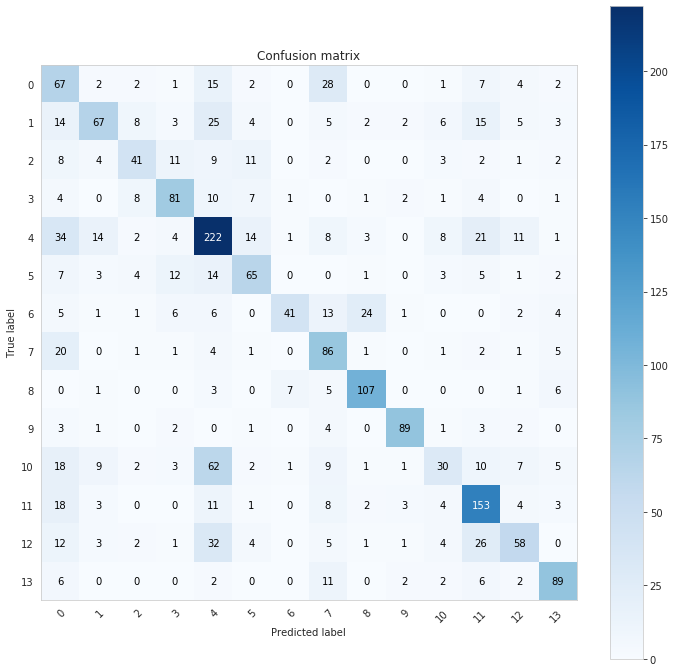

In [54]:
def visualize_confusion_matrix(y_true, y_pred, classes,
                          title=None):

    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    #setting labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # label rotation
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #bug workarond
    ax.set_ylim(len(classes)-0.5, -0.5)
    return ax

visualize_confusion_matrix(y_test, predicted_labels, classes=CLASS_NAMES,
                      title='Confusion matrix')

In [97]:
def get_wrong_indices_list_per_class(class_id,labels,predicted):
    indexes=[]
    list_predicted=predicted
    list_real=labels
    for i in range(len(list_real)):
        if list_real[i]!=list_predicted[i] and list_real[i]==class_id:
            indexes.append(i)
    return indexes

def get_class_indices(class_id,labels):
    result = np.where(labels == class_id)
    return result[0]

def visualize_n_images_horizontally(n, collection, indices_list, labels=None, predicted=None):
    sns.set_style("whitegrid", {'axes.grid' : False})
    fig, subplots = plt.subplots(1, n, figsize=(16,5))
    for subplot in subplots:
        number=random.choice(indices_list)
        ax=subplot.imshow(np.reshape(collection[number],(224, 224, 3)))
        title=str(number)
        if labels is not None:
            title+='-cl:'+CLASS_NAMES[labels[number][0]]
        if predicted is not None:
            title+='-p:'+CLASS_NAMES[predicted[number]]
        subplot.set_title(title)
    plt.show()

def visualize_n_represenative_class_examples(n,collection,labels):
    for i in range(len(CLASS_NAMES)):
        print(CLASS_NAMES[i])
        class_indices=get_class_indices(i,labels)
        visualize_n_images_horizontally(n,collection,class_indices,labels=labels)

def visualize_n_differing_for_each_class(n,collection,labels,predicted):
    for i in range(len(CLASS_NAMES)):
        print(CLASS_NAMES[i])
        mispredicted_indices=get_wrong_indices_list_per_class(i,labels,predicted)
        visualize_n_images_horizontally(n,collection,mispredicted_indices,predicted=predicted)

0


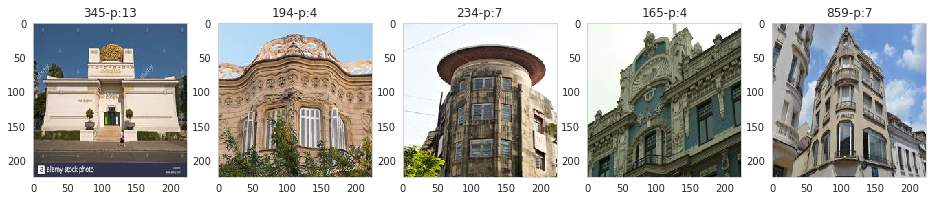

1


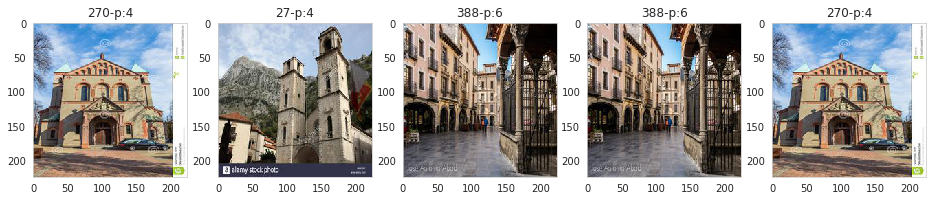

2


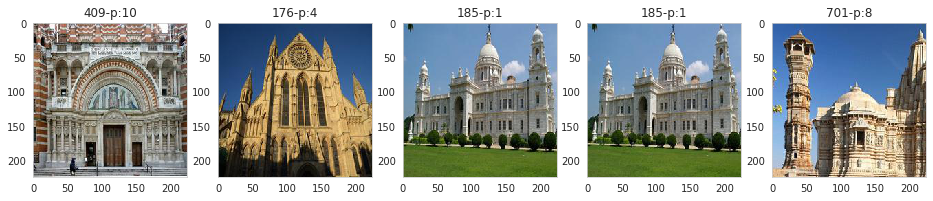

3


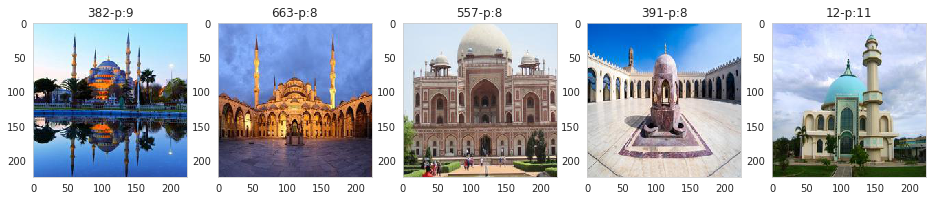

4


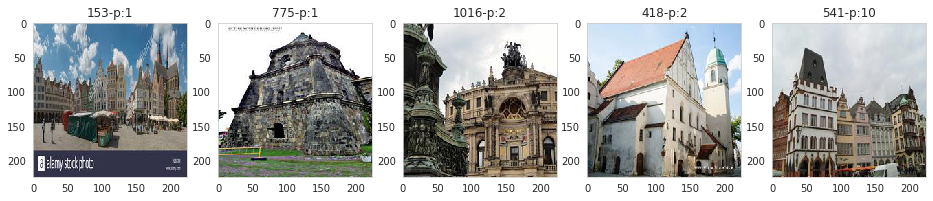

5


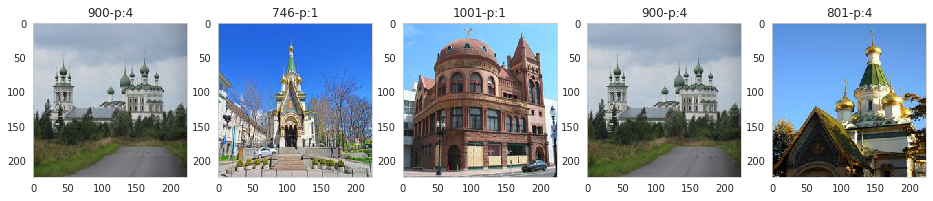

6


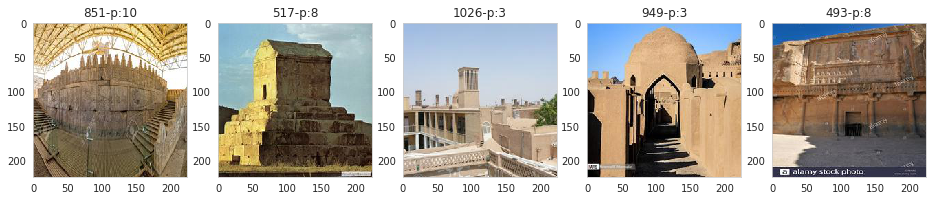

7


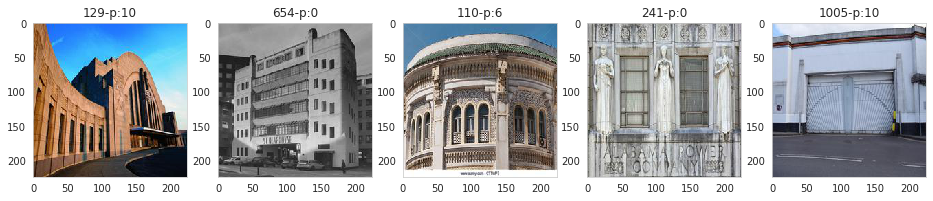

8


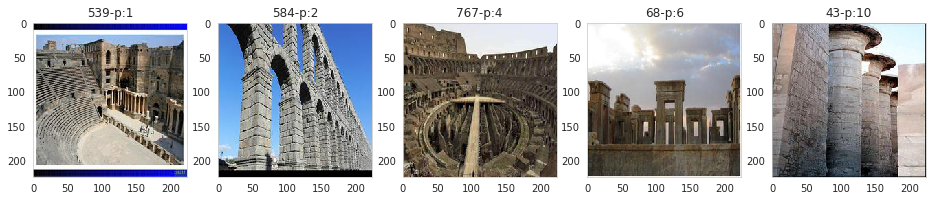

9


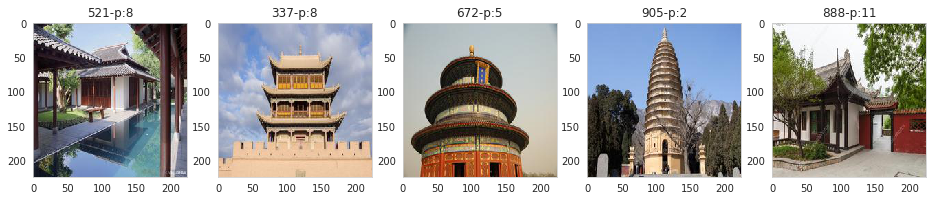

10


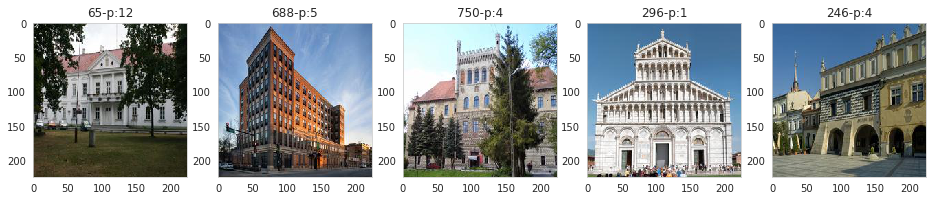

11


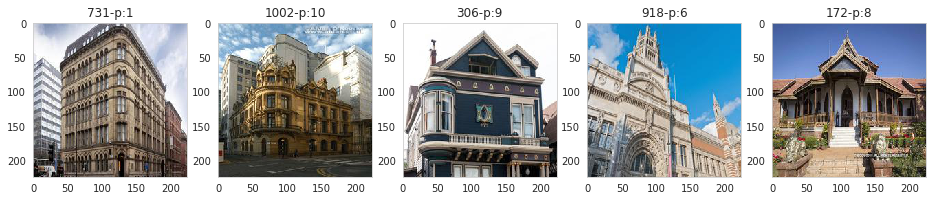

12


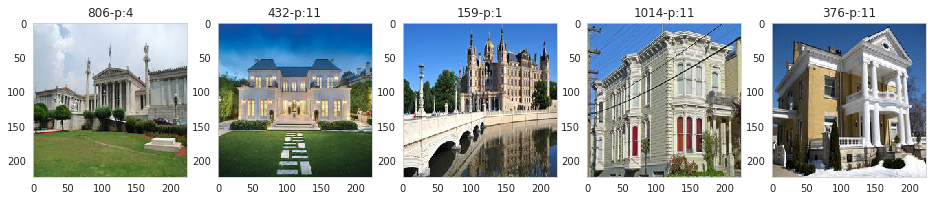

13


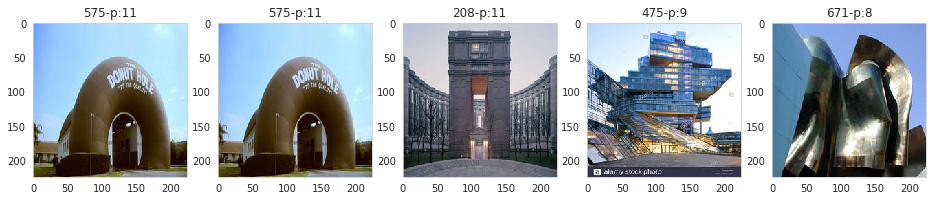

In [98]:
visualize_n_differing_for_each_class(5,x_test,y_test,predicted_labels)

In [20]:
class VGG_Model(tf.keras.Model):

    def __init__(self):
        super(VGG_Model, self).__init__()
        
        self.vgg=tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
        self.vgg.trainable=False
        
        self.flatten=Flatten()
        
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(14, activation='softmax')
         
        #STATISTICS
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]
        self.test_f1=[]
    

        
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.vgg(inputs)
        x=self.flatten(x)
        x=self.dense1(x)
        return self.dense2(x)

           

    def predict(self, x):
        res=self.call(x)
        return np.argmax(res,axis=-1)
        
    
    @tf.function
    def train_step(self,images, labels,optimizer,loss_function, train_loss_metric,train_accuracy):
        with tf.GradientTape() as tape:
            predictions = self(images)
            loss = loss_function(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        train_loss_metric(loss)
        train_accuracy(labels, predictions)
        
    @tf.function
    def test_step(self,images, labels,loss_function,test_loss_metric,test_accuracy):
        predictions = self(images)
        t_loss = loss_function(labels, predictions)
        test_loss_metric(t_loss)
        test_accuracy(labels, predictions)

    def fit(self,loss_function=tf.keras.losses.SparseCategoricalCrossentropy,
            epochs=10,optimizer=tf.keras.optimizers.Adam,learning_rate=0.001,batch_size=32,verbose=False,augmented=False):
                
        loss_function=loss_function()
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]


        train_loss_metric = tf.keras.metrics.Mean(name='train_loss_metric')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        test_loss_metric = tf.keras.metrics.Mean(name='test_loss_metric')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
        for epoch in tqdm(range(epochs)):
            
            image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        
            train_data_gen = image_generator.flow_from_directory(directory=TRAIN_PATH,
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         classes = list(CLASS_NAMES))
            
            test_data_gen = image_generator.flow_from_directory(directory=VALIDATION_PATH,
                                                                 batch_size=batch_size,
                                                                 shuffle=True,
                                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                 classes = list(CLASS_NAMES))
            if(augmented):
                augmented_generator = ImageDataGenerator(rescale=1./255,
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=[0.9, 1.1],
                rotation_range=20,
                horizontal_flip=True)
    
                train_data_augmented = augmented_generator.flow_from_directory(directory=TRAIN_PATH,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             target_size=(IMG_WIDTH,IMG_HEIGHT),
                                             classes = list(CLASS_NAMES))
            
            STEPS_PER_EPOCH_TRAIN=len(train_data_gen)-1
            STEPS_PER_EPOCH_TEST=len(test_data_gen)-1
            
            for n in range(STEPS_PER_EPOCH_TRAIN):
                batch_images,batch_labels = next(train_data_gen)
#                 batch_images=tf.image.resize(
#                     batch_images,
#                     size=(IMG_WIDTH,IMG_HEIGHT),
#                     method=tf.image.ResizeMethod.BILINEAR,
#                     preserve_aspect_ratio=False,
#                     antialias=False,
#                     name=None
#                 )
                batch_labels=np.reshape(np.argmax(batch_labels,axis=-1), newshape=(batch_size,1))
                self.train_step(batch_images, batch_labels,optimizer,loss_function,train_loss_metric,train_accuracy)
                
                if(augmented):
                    batch_images_a,batch_labels_a = next(train_data_augmented)                
                    batch_labels_a=np.reshape(np.argmax(batch_labels_a,axis=-1), newshape=(batch_size,1))
                    self.train_step(batch_images_a, batch_labels_a,optimizer,loss_function,train_loss_metric,train_accuracy)

            for t in range (STEPS_PER_EPOCH_TEST):
                test_images, test_labels = next(test_data_gen)
                test_images=tf.image.resize(
                    test_images,
                    size=(IMG_WIDTH,IMG_HEIGHT),
                    method=tf.image.ResizeMethod.BILINEAR,
                    preserve_aspect_ratio=False,
                    antialias=False,
                    name=None
                )
                test_labels=np.reshape(np.argmax(test_labels,axis=-1), newshape=(batch_size,1))
                self.test_step(test_images, test_labels,loss_function,test_loss_metric,test_accuracy)
                
            if verbose:
                template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
                print(template.format(epoch+1,
                            train_loss_metric.result(),
                            train_accuracy.result()*100,
                            test_loss_metric.result(),
                            test_accuracy.result()*100))
                
            self.train_learning_accuracy.append(train_accuracy.result().numpy()*100)
            self.test_learning_accuracy.append(test_accuracy.result().numpy()*100)
            self.train_learning_losses.append(train_loss_metric.result().numpy())
            self.test_learning_losses.append(test_loss_metric.result().numpy())

            # Reset the metrics for the next epoch
            train_loss_metric.reset_states()
            train_accuracy.reset_states()
            test_loss_metric.reset_states()
            test_accuracy.reset_states()

In [21]:
model_vgg17=VGG_Model()
# model_vgg6.fit(verbose=True,batch_size=32,epochs=50,optimizer = tf.optimizers.SGD(learning_rate=0.001, momentum=0.91),augmented=True)
model_vgg17.fit(verbose=True,batch_size=32,epochs=17,optimizer = tf.optimizers.Adam(learning_rate=0.0001),augmented=True)
# model_vgg7.fit(verbose=True,batch_size=32,epochs=20,optimizer = tfa.optimizers.AdamW(learning_rate=0.001,weight_decay=1e-4),augmented=True)

Found 8262 images belonging to 14 classes.
Found 2066 images belonging to 14 classes.
Found 8262 images belonging to 14 classes.
Epoch 1, Loss: 1.7944633960723877, Accuracy: 42.19355773925781, Test Loss: 1.46503746509552, Test Accuracy: 52.734375
Found 8262 images belonging to 14 classes.
Found 2066 images belonging to 14 classes.
Found 8262 images belonging to 14 classes.
Epoch 2, Loss: 1.3560230731964111, Accuracy: 56.38928985595703, Test Loss: 1.3961801528930664, Test Accuracy: 55.37109375
Found 8262 images belonging to 14 classes.
Found 2066 images belonging to 14 classes.
Found 8262 images belonging to 14 classes.
Epoch 3, Loss: 1.1973767280578613, Accuracy: 61.63396072387695, Test Loss: 1.3693652153015137, Test Accuracy: 55.859375
Found 8262 images belonging to 14 classes.
Found 2066 images belonging to 14 classes.
Found 8262 images belonging to 14 classes.
Epoch 4, Loss: 1.0952764749526978, Accuracy: 65.19501495361328, Test Loss: 1.3506083488464355, Test Accuracy: 56.982421875
F